In [43]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.series import Series
from pandas.io.formats.style import Styler
import seaborn as sns
from tensorflow.keras.datasets import mnist

## use display for html output
from IPython.display import display, HTML

# auto-reload modules
%load_ext autoreload
%autoreload 2

# set pandas display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 1000)

# set dark theme
plt.style.use('dark_background')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# load dataset
(trainX, trainY), (testX, testY) = mnist.load_data()

In [45]:
print(f"{trainX.shape =}, {trainY.shape =}, {testX.shape =}, {testY.shape =}")

trainX.shape =(60000, 28, 28), trainY.shape =(60000,), testX.shape =(10000, 28, 28), testY.shape =(10000,)


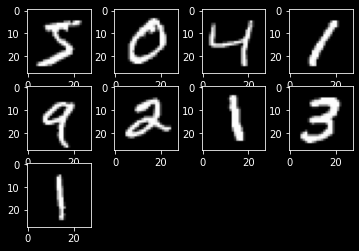

In [46]:
# plot first few images
n_cols = 4
n_rows = 3
for i in range(9):
    # subplot_index = 341 i.e 3 rows, 4 columns, 1st plot
    subplot_index = n_rows*100 + n_cols*10 +  i + 1
    plt.subplot(subplot_index)
    plt.imshow(trainX[i], cmap='gray')
# show the figure
plt.show()

del i, n_cols, n_rows, subplot_index

In [47]:
def normalize_images(images):
    """Normalize images to [0, 1] range"""
    return images.astype('float32') / 255.0

In [48]:
trainX, testX = normalize_images(trainX), normalize_images(testX)

In [49]:
from tensorflow.keras.utils import to_categorical
# one-hot encode target values
# 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
# this is to make the model learn the probability of each class
trainY, testY = to_categorical(trainY), to_categorical(testY)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD

def add_layers(model):
    """ Creates a model with layers """
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    return model

def compile_model(model):
    """ Compile the model """
    opt = SGD(learning_rate=0.01, momentum=0.9)
    # sparse_categorical_crossentropy
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_seq_model() -> Sequential:
    """ Create a model """
    model = Sequential()
    model = add_layers(model)
    model = compile_model(model)
    model: Sequential = model
    return model

In [51]:
from sklearn.model_selection import KFold

def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = create_seq_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY))
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories


In [52]:
from statistics import mean, stdev

# plot diagnostic learning curves
def show_learning_curve(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, stdev(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

In [53]:
# scores, histories = evaluate_model(trainX, trainY, n_folds=1)
# # # learning curves
# show_learning_curve(histories)
# # # summarize estimated performance
# summarize_performance(scores)

In [54]:
# train the model
model = create_seq_model()
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY))

Epoch 1/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.1741 - accuracy: 0.9465 - val_loss: 0.0699 - val_accuracy: 0.9774
Epoch 2/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0577 - accuracy: 0.9824 - val_loss: 0.0525 - val_accuracy: 0.9840
Epoch 3/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0367 - accuracy: 0.9885 - val_loss: 0.0450 - val_accuracy: 0.9860
Epoch 4/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0256 - accuracy: 0.9919 - val_loss: 0.0507 - val_accuracy: 0.9831
Epoch 5/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0170 - accuracy: 0.9946 - val_loss: 0.0572 - val_accuracy: 0.9819
Epoch 6/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0129 - accuracy: 0.9964 - val_loss: 0.0393 - val_accuracy: 0.9874
Epoch 7/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0082 - accuracy: 0.9978 - val_loss: 0.0438 -

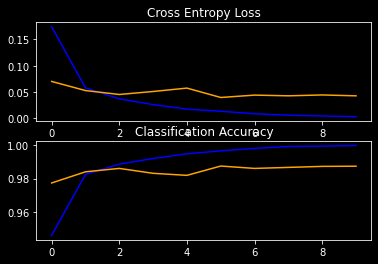

In [55]:
show_learning_curve([history])

In [56]:
# evaluate the model
_, acc = model.evaluate(testX, testY, verbose=0)
print(f"{acc*100:.3f}")

# save the model
model.save('1 to 9 digit_recognition_model.h5')

98.730


In [57]:
## load the model
from tensorflow.keras.models import load_model
model = load_model('1 to 9 digit_recognition_model.h5')
_, acc = model.evaluate(testX, testY, verbose=0)
print(f"{acc*100:.3f}")

98.730
